[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/NiCALab-IMAL/SupportiveBackwardAdaptation/blob/main/A2_Evaluate_different_training_sessions.ipynb)

#Co-adaptive BCI based on supervised domain adaptation: results in motor imagery simulated data

Notebook credits: Valeria Spagnolo, Catalina Galván, [Victoria Peterson](https://sites.google.com/view/victoria-peterson/home)

Laboratorio de Neuroingeniería Computacional Aplicada, Instituto de Matemática Aplicada del Litoral, IMAL, UNL-CONICET
https://sites.google.com/view/nicalab



### Demo for testing A2: “The source data, where the classifier is trained, must define a discriminative space to perform reliable backward domain adaptation.”

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Install and import the necessary libraries

In [2]:
!pip install wget
!pip install mne
!pip install POT
!pip install pyriemann
!git clone https://github.com/vpeterson/otda-mibci.git

fatal: destination path 'otda-mibci' already exists and is not an empty directory.


In [3]:
import wget
import numpy as np
import sys
import os
import os.path as op
import timeit
import random
from random import sample
import matplotlib.pyplot as plt
import mne
from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.classification import class_distinctiveness
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

sys.path.insert(1, 'otda-mibci')
from MIOTDAfunctions import SelectSubsetTraining_BOTDAl1l2
from SBA import SBA

mne.set_log_level(verbose='warning') # to avoid info at terminal

random.seed(42)


## Define SBA parameters

In [4]:
botda_params = {"range_cl":  [1],
                "range_e" : [0.1],
                "metric": "sqeuclidean",
                "innerkfold": "None",
                "outerkfold" : 20,
                "M": 20,
                "norm": "max",
                "eps":1e+6,
                "SVMAX": 20}
rango_e = botda_params["range_e"]
rango_cl = botda_params["range_cl"]
metric = botda_params["metric"]
outerkfold = botda_params["outerkfold"]
if botda_params["innerkfold"] ==  "None":
    innerkfold = None
M = botda_params["M"]
norm = botda_params["norm"]

# Part 1: Impact of a low self-regulation capability in source data

## Load and prepare training data
First, we load and prepare training session data. For this part of the study, we will use as training session $S_{10, 0}$, i.e., a session corresponding to a low self-regulation capability but without any failed trial.



In [5]:
# Load training data
wget.download("https://zenodo.org/records/13760210/files/S_10_epo.fif?download=1",
              out="S_10_epo.fif")
epochs_train = mne.read_epochs("S_10_epo.fif", preload=True, verbose=False)
# Resample to 250 Hz
epochs_train = epochs_train.resample(250)
# Get epoched data as a numpy array
epochs_train_array = epochs_train.get_data()
# Filter data between 8 an 30 Hz
epochs_train_array = mne.filter.filter_data(epochs_train_array, 250, 8, 30)

We can check the discriminability of training data by using classDistinctiveness metric.

In [6]:
Xtr = epochs_train_array.copy()
Ytr = epochs_train.events[:, 2].copy()
cov_data_train_rest = Covariances(estimator="lwf").transform(Xtr[Ytr==2])
cov_data_train_MI = Covariances(estimator="lwf").transform(Xtr[Ytr==1])

cov_aux_rmitr = np.concatenate((cov_data_train_MI, cov_data_train_rest), axis=0)

Yaux_RMItr = np.zeros(len(cov_aux_rmitr))
Yaux_RMItr[:len(cov_data_train_rest)] = 1
distinctiveness = class_distinctiveness(cov_aux_rmitr, Yaux_RMItr,exponent=2)

print('Class distinctiveness: ' + str(round(distinctiveness, 3)))

Class distinctiveness: 0.34


## Load and prepare testing data

During the first part of this demo, testing session will be $S_{50,0}$,  that is, the perfect session at which all trials are aligned to their corresponding class and have ERD% = 50.

In [7]:
wget.download("https://zenodo.org/records/13760210/files/S_50_epo.fif?download=1",
              out="S_50_epo.fif")
epochs_test = mne.read_epochs("S_50_epo.fif", preload=True, verbose=False)
# Resample to 250 Hz
epochs_test = epochs_test.resample(250)
epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array
# Band-pass filter
epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30)

## Split testing session data into validation and testing sets.

We generate a class-balanced validation set with SVMAX trials from the beggining of the testing session. The remaining trials are used for testing.

In [8]:
# Sort testing data to accomplish that validation set is always class-balanced
# Combine for sorting
combined_data = list(zip(epochs_test_array, epochs_test.events[:, 2]))
# Get the indices of class 1 and class 2 epochs
class_1_indices = np.where(epochs_test.events[:, 2] == 1)[0]
class_2_indices = np.where(epochs_test.events[:, 2] == 2)[0]
# Interleave class 1 and class 2 indices to alternate between classes
sorted_indices = np.empty(len(epochs_test_array), dtype=int)
sorted_indices[0::2] = class_1_indices
sorted_indices[1::2] = class_2_indices
# Reorder the combined data using the sorted indices
epoch_test_sorted = [combined_data[i][0] for i in sorted_indices]
event_test_sorted = [combined_data[i][1] for i in sorted_indices]
# Convert back to numpy arrays
epoch_test_sorted = np.array(epoch_test_sorted)
event_test_sorted = np.array(event_test_sorted)

Xte = epoch_test_sorted[botda_params["SVMAX"]:].copy()  # Epoched data as a numpy array
Yte = event_test_sorted[botda_params["SVMAX"]:].copy()
# use the first 20 samples for validation
Xval = epoch_test_sorted[:botda_params["SVMAX"]].copy()  # Epoched data as a numpy array
Yval = event_test_sorted[:botda_params["SVMAX"]].copy()


## Fit the model
Then, we train CSP + LDA at source data. Let's also calculate the training accuracy, plot the training features and the corresponding CSP patterns.

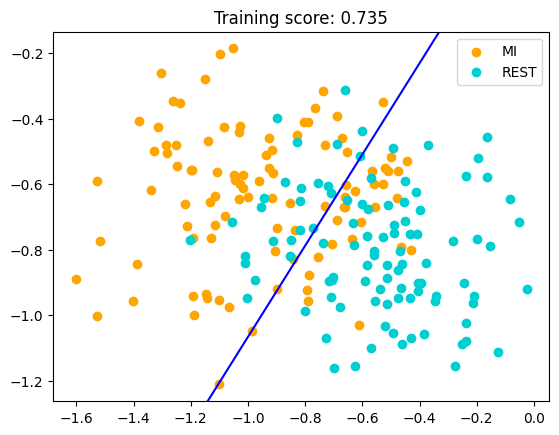

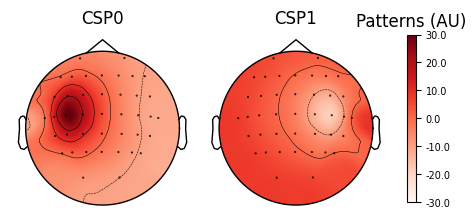

In [9]:
# Create CSP and LDA objects
csp = CSP(n_components=2, reg='empirical', log=True, norm_trace=False, cov_est='epoch') #creating obj
lda = LinearDiscriminantAnalysis()
# Learn CSP filters
Gtr = csp.fit_transform(Xtr, Ytr)
# Fit LDA
lda.fit(Gtr, Ytr)

# Get the accuracy at training data
acc_tr = lda.score(Gtr, Ytr)

# Plot first 2 CSP features of the training set + the LDA decision boundary
features = Gtr[:,0:2]
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='orange', label='MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='darkturquoise', label='REST')
axs.set_title("Training score: " + str(lda.score(Gtr,Ytr)))
axs.legend()
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
xlim = xx
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue')
axs.set_ylim(ylim)
axs.set_xlim(xlim)

# Plot CSP patterns
fig = csp.plot_patterns(epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5, cmap='Reds')


Let's test our model without and with domain adaptation at the perfect session data!

In [10]:
# Calculate testing and validation CSP features
Gte = csp.transform(Xte)
Gval = csp.transform(Xval)

# Predict the testing classes using LDA and calculate testing accuracy
y_predict_lda = lda.predict(Gte)
acc_lda = (accuracy_score(Yte, y_predict_lda))

# Print testing LDA accuracy
print('Testing accuracy LDA (without adaptation): ' + str(round(acc_lda, 3)))

Testing accuracy LDA (without adaptation): 0.822


In [11]:
y_predict_ot = []  # Initialize list to store predicted classes
Transp = []   # Initialize list to store transported features

# Select source subset based on CV and validation features
G_botdatr, Y_botdatr, reg_botda=\
SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)
# Create SBA object
sba = SBA(reg_botda, lda, botda_params["metric"])

# For each testing trial
for re in range(0, len(Yte)):
    # Testing trial
    Xte_ = Xte[re:re+1]
    Yte_ = Yte[re:re+1]

    # Append to the Xval subset the current testing trial
    Xval_ = np.vstack((Xval.copy(), Xte_))
    Yval_ = np.hstack((Yval.copy(), Yte_))

    # Calculate validation and testing CSP features
    Gval_ = csp.transform(Xval_)
    Gte_ = csp.transform(Xte_)

    # Learn the transport based on the selected source subset and the current validation subset
    sba.fit(G_botdatr, Gval_, Yval_)
    # Transport testing feature and predict its class
    Gte_transported, y_pred_ = sba.transform(Gte_)
    Transp.append(Gte_transported)
    y_predict_ot.append(y_pred_)


Gte_ot = np.squeeze(Transp)
y_predict_ot = np.squeeze(y_predict_ot)

# Calculate accuracy
acc_OT = accuracy_score(Yte,y_predict_ot)
print('Testing accuracy SBA: ' + str(round(acc_OT, 3)))

Testing accuracy SBA: 0.994


# Part 2: Impact of trials not belonging to the indicated task in source data

For this part of the study, we will use as source data session $S_{50, 40}$, i.e., a session corresponding to a high self-regulation capability but with a high percentage of failed trials.

In the following we repeat the same steps as before but using now for training the $S_{50, 40}$ session. For doing so, first we load the $S_{50, 0}$ data and we flip the labels for 40% of the trials.

In [12]:
# Load training data
epochs_train = mne.read_epochs("S_50_epo.fif", preload=True, verbose=False)
# Resample to 250 Hz
epochs_train = epochs_train.resample(250)
# Get epoched data as a numpy array
epochs_train_array = epochs_train.get_data()
# Filter data between 8 an 30 Hz
epochs_train_array = mne.filter.filter_data(epochs_train_array, 250, 8, 30)
# Proportion of "failed" trials
p = 0.4
Xtr = epochs_train_array.copy()
Ytr = epochs_train.events[:, 2].copy()
indices_2 = np.where(Ytr == 2)[0] # Rest class indices
indices_1 = np.where(Ytr == 1)[0] # MI class indices
# Select the trials where the label will be changed. Here, for reproducibility
# we use the same indices randomly selected when running the experiments. In the
# next two lines you can also find how to do this random selection.
indices_change_1 = [165, 128, 152, 46, 34, 93, 36, 136, 132, 0, 151, 80, 123,
                    2, 23, 91, 76, 60, 9, 166, 143, 15, 154, 177, 11, 133, 26,
                    144, 120, 138, 39, 68, 182, 109, 50, 192, 167, 197, 81, 178]
indices_change_2 = [56, 38, 134, 127, 29, 17, 33, 42, 159, 45, 172, 106, 155,
                    20, 97, 96, 175, 115, 137, 65, 142, 8, 188, 140, 67, 89,
                    156, 77, 111, 181, 114, 6, 66, 131, 48, 135, 31, 145, 84,
                    185]
Ytr[indices_change_2] = 1
Ytr[indices_change_1] = 2

## Load, prepare and split testing data

Now testing session will be $S_{45,0}$,  that is, the perfect session at which all trials are aligned to their corresponding class and have ERD% = 45. In the following, as before, we load test data, prepare it and split it in validation and testing subsets.

In [13]:
wget.download("https://zenodo.org/records/13760210/files/S_45_epo.fif?download=1",
              out="S_45_epo.fif")
epochs_test = mne.read_epochs("S_45_epo.fif", preload=True, verbose=False)
# Resample to 250 Hz
epochs_test = epochs_test.resample(250)
epochs_test_array = epochs_test.get_data()  # Epoched data as a numpy array
# Band-pass filter
epochs_test_array=mne.filter.filter_data(epochs_test_array, 250, 8, 30)

# Sort testing data to accomplish that validation set is always class-balanced
# Combine for sorting
combined_data = list(zip(epochs_test_array, epochs_test.events[:, 2]))
# Get the indices of class 1 and class 2 epochs
class_1_indices = np.where(epochs_test.events[:, 2] == 1)[0]
class_2_indices = np.where(epochs_test.events[:, 2] == 2)[0]
# Interleave class 1 and class 2 indices to alternate between classes
sorted_indices = np.empty(len(epochs_test_array), dtype=int)
sorted_indices[0::2] = class_1_indices
sorted_indices[1::2] = class_2_indices
# Reorder the combined data using the sorted indices
epoch_test_sorted = [combined_data[i][0] for i in sorted_indices]
event_test_sorted = [combined_data[i][1] for i in sorted_indices]
# Convert back to numpy arrays
epoch_test_sorted = np.array(epoch_test_sorted)
event_test_sorted = np.array(event_test_sorted)

Xte = epoch_test_sorted[botda_params["SVMAX"]:].copy()  # Epoched data as a numpy array
Yte = event_test_sorted[botda_params["SVMAX"]:].copy()
# use the first 20 samples for validation
Xval = epoch_test_sorted[:botda_params["SVMAX"]].copy()  # Epoched data as a numpy array
Yval = event_test_sorted[:botda_params["SVMAX"]].copy()

## Fit the model
Then, we train CSP + LDA at source data. Let's also calculate the training accuracy, plot the training features and the corresponding CSP patterns.

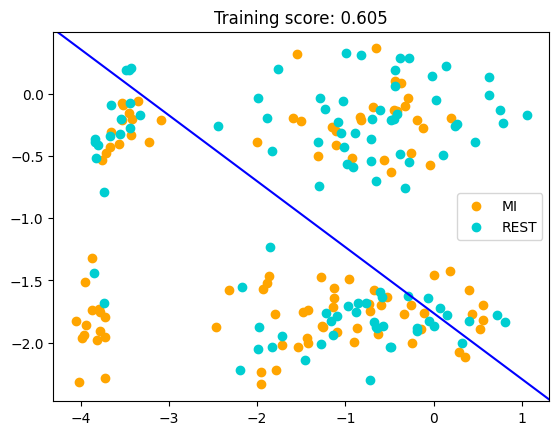

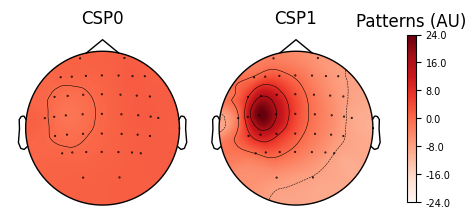

In [14]:
# Create CSP and LDA objects
csp = CSP(n_components=2, reg='empirical', log=True, norm_trace=False, cov_est='epoch') #creating obj
lda = LinearDiscriminantAnalysis()
# Learn CSP filters
Gtr = csp.fit_transform(Xtr, Ytr)
# Fit LDA
lda.fit(Gtr, Ytr)

# Get the accuracy at training data
acc_tr = lda.score(Gtr, Ytr)

# Plot first 2 CSP features of the training set + the LDA decision boundary
features = Gtr[:,0:2]
fig, axs = plt.subplots()
axs.scatter(features[Ytr==1, 0], features[Ytr==1, 1], c='orange', label='MI')
axs.scatter(features[Ytr==2, 0], features[Ytr==2, 1], c='darkturquoise', label='REST')
axs.set_title("Training score: " + str(lda.score(Gtr,Ytr)))
axs.legend()
b, w1, w2 = lda.intercept_[0], lda.coef_[0][0], lda.coef_[0][1]
xx = np.array(axs.get_xlim())
xlim = xx
ylim = np.array(axs.get_ylim())
axs.plot(xx, -(b+xx*w1)/w2, c='blue')
axs.set_ylim(ylim)
axs.set_xlim(xlim)

# Plot CSP patterns
fig = csp.plot_patterns(epochs_train.info, ch_type='eeg', units='Patterns (AU)', size=1.5, cmap='Reds')


Let's again test our model without and with BOTDA at the $S_{45, 0}$ session data!

In [15]:
# Calculate testing and validation CSP features
Gte = csp.transform(Xte)
Gval = csp.transform(Xval)

# Predict the testing classes using LDA and calculate testing accuracy
y_predict_lda = lda.predict(Gte)
acc_lda = (accuracy_score(Yte, y_predict_lda))

# Print testing LDA accuracy
print('Testing accuracy LDA (without adaptation): ' + str(round(acc_lda, 3)))

Testing accuracy LDA (without adaptation): 0.8


In [16]:
y_predict_ot = []  # Initialize list to store predicted classes
Transp = []   # Initialize list to store transported features

# Select source subset based on CV and validation features
G_botdatr, Y_botdatr, reg_botda=\
SelectSubsetTraining_BOTDAl1l2(Gtr, Ytr, Gval, Yval, rango_e, rango_cl, lda, metric, outerkfold, innerkfold, M, norm)
# Create SBA object
sba = SBA(reg_botda, lda, botda_params["metric"])

# For each testing trial
for re in range(0, len(Yte)):
    # Testing trial
    Xte_ = Xte[re:re+1]
    Yte_ = Yte[re:re+1]

    # Append to the Xval subset the current testing trial
    Xval_ = np.vstack((Xval.copy(), Xte_))
    Yval_ = np.hstack((Yval.copy(), Yte_))

    # Calculate validation and testing CSP features
    Gval_ = csp.transform(Xval_)
    Gte_ = csp.transform(Xte_)

    # Learn the transport based on the selected source subset and the current validation subset
    sba.fit(G_botdatr, Gval_, Yval_)
    # Transport testing feature and predict its class
    Gte_transported, y_pred_ = sba.transform(Gte_)
    Transp.append(Gte_transported)
    y_predict_ot.append(y_pred_)


Gte_ot = np.squeeze(Transp)
y_predict_ot = np.squeeze(y_predict_ot)

# Calculate accuracy
acc_OT = accuracy_score(Yte,y_predict_ot)
print('Testing accuracy SBA: ' + str(round(acc_OT, 3)))


Testing accuracy SBA: 0.8
